# Prepare notebook

In [4]:
# Download the Spanish language model for spaCy
!pip install swifter
!python -m spacy download es_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.8.0/es_core_news_sm-3.8.0-py3-none-any.whl (12.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


## Import relevant libraries

In [5]:
import re
import pandas as pd
import numpy as np
import spacy
import swifter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import Image, display

# Load the Spanish language model
nlp = spacy.load("es_core_news_sm")

/home/rmessina/anaconda3/envs/eli/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Some helpers

In [6]:
def clean_lyrics(letra):
    cleaned = ''
    for text in letra.split('\n')[1:]:   # remove the first line
        if text == '':
            continue
        text = re.sub(r'\[.+?\]', ' ', text) # remove whatever is between brackets
        text = re.sub(r'\((.+?)\)', r'\1', text) # keep what is between parentheses
        text = re.sub(r'\"(.+?)\"', r'\1', text) # keep what is between quotes
        text = re.sub('[\s]+', ' ', text) # spaces
        text = text.strip() # remove leading and trailing spaces
        text = text.lower() # lowercase
        cleaned += text + ' '
    cleaned = re.sub(r'\s+', ' ', cleaned) # remove multiple spaces
    cleaned = cleaned.strip() # remove leading and trailing spaces
    return cleaned


def load_data(
        csv_path: str,
        languages: list = None,
        chunk_size: int = 20000
        ) -> pd.DataFrame:
    # dafault is Spanish
    if languages is None:
        languages = ['es']
    # Read the CSV file in chunks
    chunks = pd.read_csv(csv_path, chunksize=chunk_size, encoding='utf-8')
    # Process each chunk
    filtered_chunks = []
    for chunk in chunks:
        filtered_chunk = chunk[chunk['language'].isin(languages)]
        filtered_chunks.append(filtered_chunk)
    # Combine all filtered chunks into a single DataFrame
    filtered_df = pd.concat(filtered_chunks)
    return filtered_df



## Let's clean-up and do some normalization to the lyrics

In [7]:
data_soure = '/mnt/c/Users/rmessina/Eli/data/song_lyrics_es_1950_2020.csv'

df = load_data(data_soure, languages=['es'])
df['cleaned_lyrics'] = df['lyrics'].swifter.apply(clean_lyrics)
df.columns

Pandas Apply: 100%|██████████| 275059/275059 [00:54<00:00, 5008.17it/s]


Index(['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'id',
       'language_cld3', 'language_ft', 'language', 'decade', 'cleaned_lyrics'],
      dtype='object')

# Lemmatization

In [33]:
def lemmatize_text(text):
    """
    Lemmatize the input text using spaCy's Spanish language model,
    excluding stopwords.
    """
    doc = nlp(text)
    return " ".join([
        token.lemma_ for token in doc 
        if not token.is_punct and not token.is_space and not token.is_stop
    ])

# df_short = df.sample(5000, random_state=42)  # Sample 1000 rows for faster processing
df_short = df

# Apply lemmatization using swifter
df_short['lemmatized_lyrics'] = df_short['cleaned_lyrics'].swifter.apply(lemmatize_text)

df_short.to_csv('/mnt/c/Users/rmessina/Eli/data/song_lyrics_es_1950_2020_lemmatized_lyrics.csv', index=False, encoding='utf-8')


Pandas Apply: 100%|██████████| 275059/275059 [1:19:53<00:00, 57.39it/s]  


# Count unique lemmas per decade

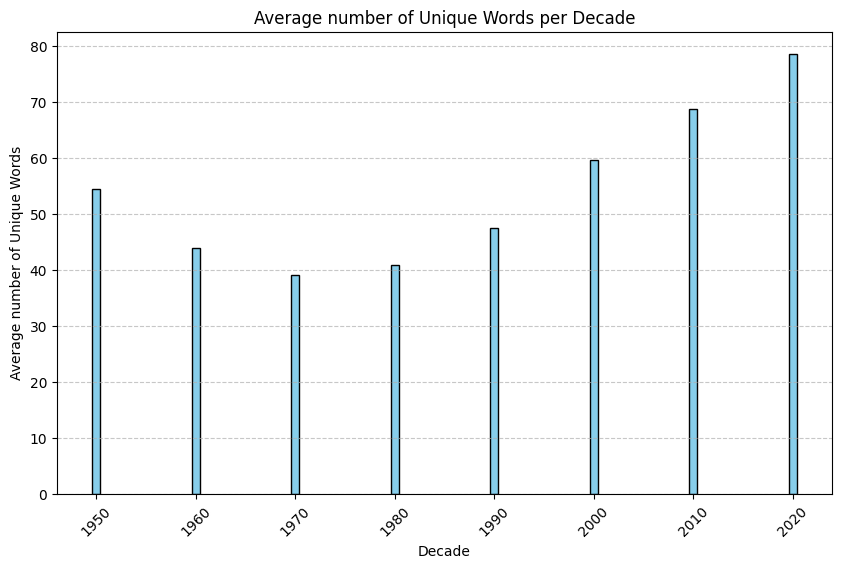

In [34]:
# Group by decade and calculate the average number of unique words per song
def average_unique_words_per_decade(a_df):
    avg_unique_words_per_decade = {}
    for decade, group in a_df.groupby('decade'):
        unique_word_counts = group['lemmatized_lyrics'].apply(lambda x: len(set(x.split())))
        avg_unique_words_per_decade[decade] = unique_word_counts.mean()
    return avg_unique_words_per_decade

# Get the unique word counts
avg_words_per_decade = average_unique_words_per_decade(df_short)

# Plot the number of unique words per decade
plt.figure(figsize=(10, 6))
plt.bar(avg_words_per_decade.keys(), avg_words_per_decade.values(), color='skyblue', edgecolor='black')
plt.xlabel('Decade')
plt.ylabel('Average number of Unique Words')
plt.title('Average number of Unique Words per Decade')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Songs per decade

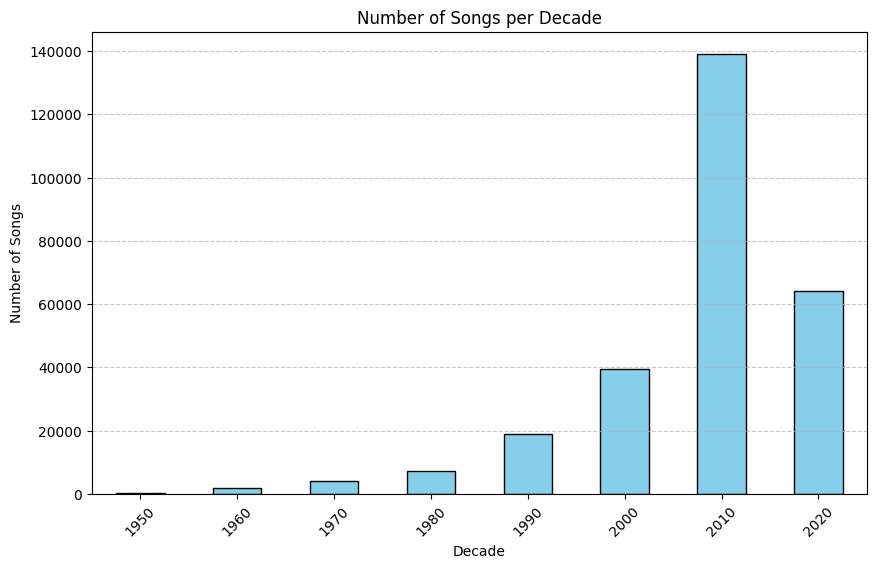

In [35]:
songs_per_decade = df_short.groupby('decade').size()

# Plot the number of songs per decade
plt.figure(figsize=(10, 6))
songs_per_decade.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.title('Number of Songs per Decade')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Let's look at the clouds

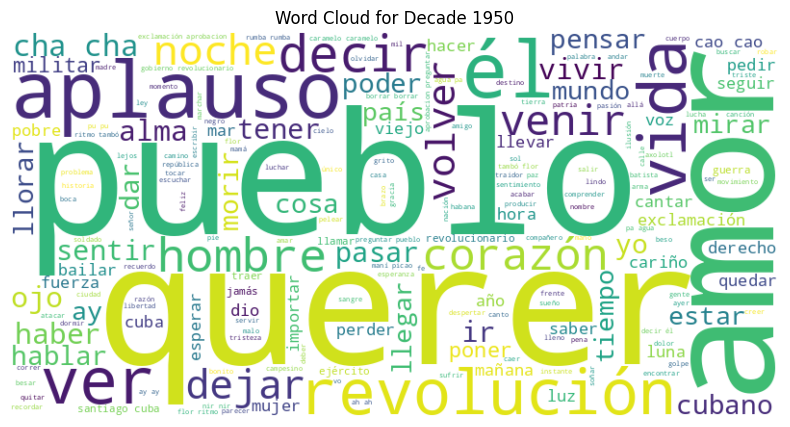

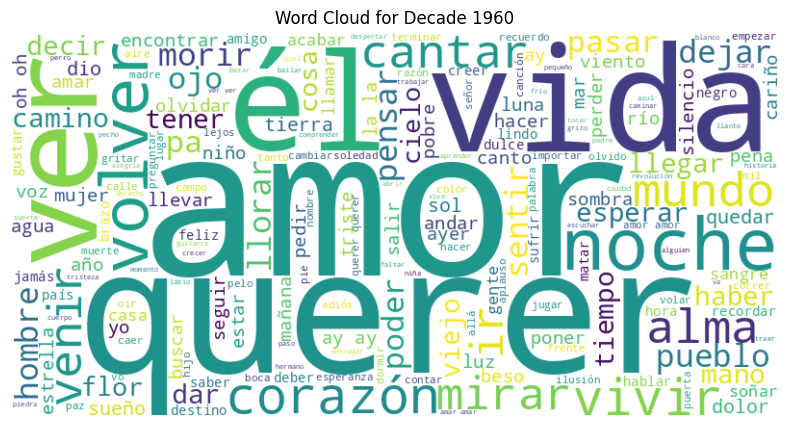

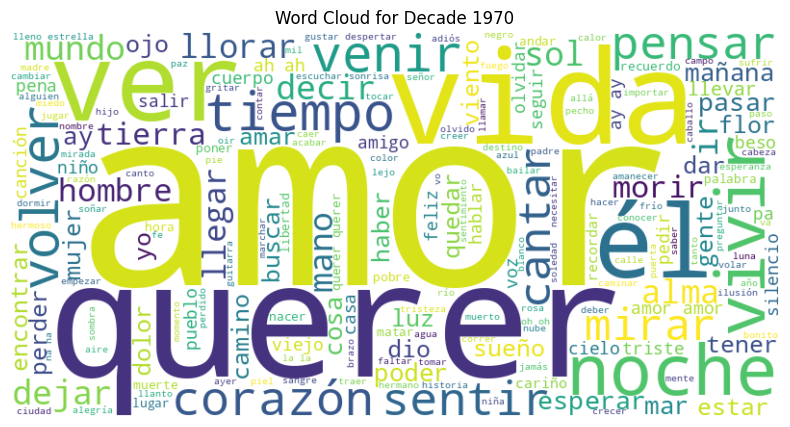

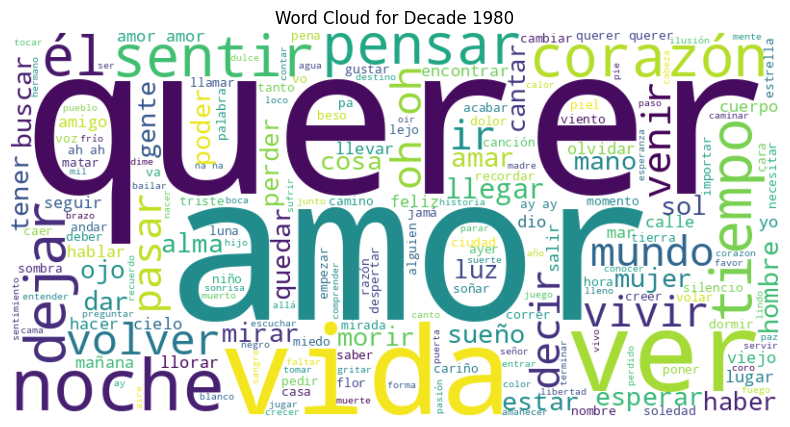

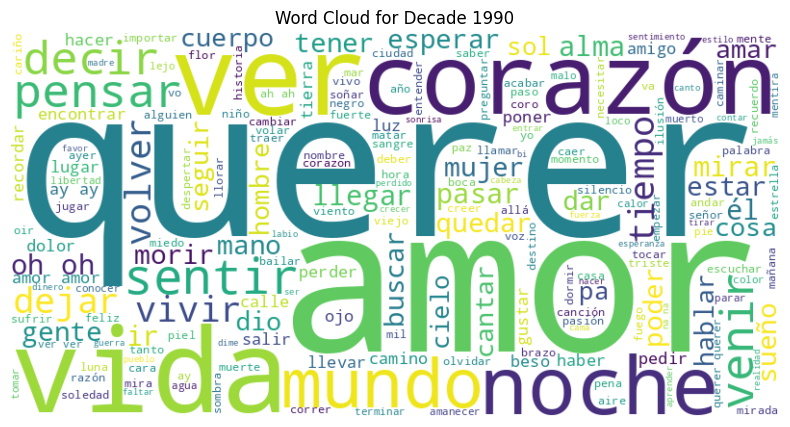

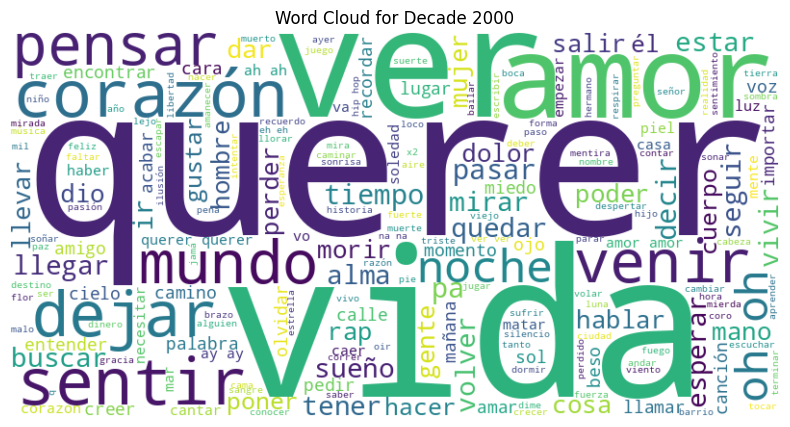

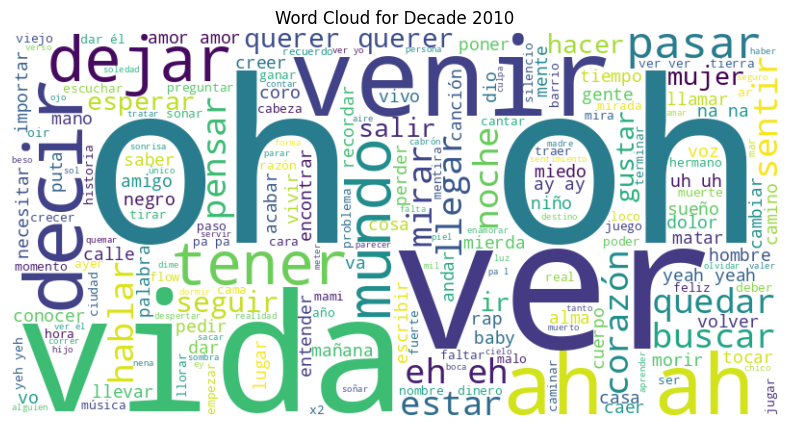

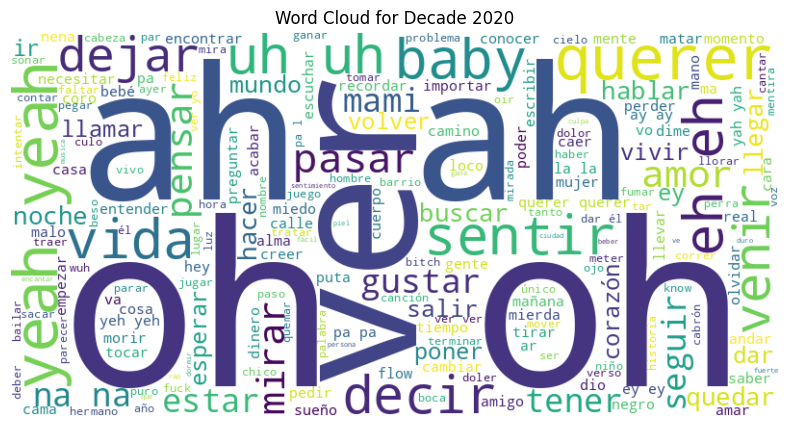

In [36]:
# Generate word clouds for each decade
for decade, group in df_short.groupby('decade'):
    # Concatenate all lyrics for the decade
    all_words = " ".join(group['lemmatized_lyrics'])
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_words)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Decade {decade}")
    plt.show()

# Let's do some more visualizations

In [11]:
!pip install sentence-transformers umap-learn plotly
!pip install --upgrade nbformat
!pip show nbformat

Name: nbformat
Version: 5.10.4
Summary: The Jupyter Notebook format
Home-page: https://jupyter.org
Author: 
Author-email: Jupyter Development Team <jupyter@googlegroups.com>
License: BSD 3-Clause License
        
        - Copyright (c) 2001-2015, IPython Development Team
        - Copyright (c) 2015-, Jupyter Development Team
        
        All rights reserved.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        1. Redistributions of source code must retain the above copyright notice, this
           list of conditions and the following disclaimer.
        
        2. Redistributions in binary form must reproduce the above copyright notice,
           this list of conditions and the following disclaimer in the documentation
           and/or other materials provided with the distribution.
        
        3. Neither the name of the copyright holder nor

In [37]:
from sentence_transformers import SentenceTransformer
import torch

# Check if GPU is available
print(f"Is CUDA available? {torch.cuda.is_available()}")
print(f"Number of GPUs available: {torch.cuda.device_count()}")
print(f"Current GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")


# Load a Spanish S-BERT model
sbert_model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es', device='cuda')

# Generate embeddings for the lemmatized lyrics
df_short['sbert_embeddings'] = df_short['lemmatized_lyrics'].apply(lambda x: sbert_model.encode(x))

df_short.to_csv('/mnt/c/Users/rmessina/Eli/data/song_lyrics_es_1950_2020_sbert.csv', index=False, encoding='utf-8')

Is CUDA available? True
Number of GPUs available: 1
Current GPU: NVIDIA RTX 3500 Ada Generation Laptop GPU


: 

In [15]:
import umap.umap_ as umap

# Convert embeddings to a NumPy array
embeddings = np.vstack(df_short['sbert_embeddings'].values)

# Apply UMAP to reduce dimensions to 2D
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Add UMAP coordinates to the DataFrame
df_short['umap_x'] = umap_embeddings[:, 0]
df_short['umap_y'] = umap_embeddings[:, 1]

/home/rmessina/anaconda3/envs/eli/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [17]:
import plotly.express as px

# Create an interactive scatter plot
fig = px.scatter(
    df_short,
    x='umap_x',
    y='umap_y',
    hover_data=['decade'],  # Add index and lyrics as hover info
    title='UMAP Visualization of Lyrics Embeddings',
    labels={'umap_x': 'UMAP X', 'umap_y': 'UMAP Y'}
)

# Show the plot
fig.show()

# Topic modeling

In [ ]:
!pip install scikit-learn gensim

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 11.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 42.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [pyLDAvis]4/5 [pyLDAvis]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,  # Ignore terms that appear in more than 95% of documents
    min_df=2,     # Ignore terms that appear in fewer than 2 documents
    stop_words=None,  # Stopwords are already removed during lemmatization
    max_features=5000  # Limit the number of features for efficiency
)

# Fit and transform the lemmatized lyrics
tfidf_matrix = tfidf_vectorizer.fit_transform(df_short['lemmatized_lyrics'])

# Get feature names (words)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [32]:
# Define the number of topics
num_topics = 6

# Create and fit the LDA model
lda_model = LatentDirichletAllocation(
    n_components=num_topics,  # Number of topics
    random_state=42,
    learning_method='batch'
)
lda_model.fit(tfidf_matrix)

# Get the top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print()

# Display the top words for each topic
display_topics(lda_model, tfidf_feature_names, num_top_words=20)

Topic 1:
the you my got in up and we it your but with on all implorar amándote of they that for

Topic 2:
querer amor pa ver él vida oh sentir yo dejar volver noche pasar tiempo corazón dar decir ah pensar vivir

Topic 3:
muévelo bum tra pew nar salimo regalartir dad pary lila wo súbelo telefono esconda tonight plo gelato deshecha buscándomir você

Topic 4:
nir ra lola bésame cariñito olé jehová ie atreveer pipo speed decírtelo gua eléctrico gorila sara bandida acaríciame der botar

Topic 5:
uuuh sonidero sálvese bailemo elevo mirame eeh bailé weekend automático teta suero futbolista dad mentirós honra lao aguante clavelito imperialismo

Topic 6:
querer amor oh sentir amar olvidar pensar vida estar ir volver yo dime doler corazón ver ay poder tiempo dejar



In [22]:
# Get the topic distribution for each document
topic_distributions = lda_model.transform(tfidf_matrix)

# Assign the most likely topic to each song
df_short['topic'] = topic_distributions.argmax(axis=1)

# Display the first few rows with topics
df_short[['lemmatized_lyrics', 'topic']].head()

lemmatized_lyrics  topic
131159  foto montaje champán caviar vagar red mentir p...      1
244511  digital onir laboratorio sorprender cante pa s...      1
7508    sol listo verte listo celda destino cruel ver ...      1
272783  perdón pasar cumplir error doler estés vo escu...      1
248820  querer comentario canción recordar oración com...      1